# Цель работы: 
### Выяснить является ли данная выборка экпертов валидной для метода экспертных оценок


# План работы: 
1. Первичная обрaботка данных
2. Исследовательский анализ данных
3. Рассмотрение корреляции признаков 
4. Кластеризация и ее последующий анализ
5. Вывод 

## Выдвинем гипотезы для последующей проверки
- гипотеза 1: дисперсия характеристик исходной группы должна быть примерно равна дисперсии каждрой из подгрупп
- гипотеза 2: существует прямая корреляция между образованием и уровнем должности
- гипотеза 3: чем выше должность, тем больше доля мужчин

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import statsmodels.api as sm
from phik.report import plot_correlation_matrix
from scipy.stats import spearmanr
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, OPTICS
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import warnings
warnings.filterwarnings("ignore")

 ## Первичная обработка данных

In [30]:
path = "данные для обработки.xlsx"
try:
    df = pd.read_excel(path)
except:
    raise FileNotFoundError('Файл не найден')

In [31]:
def data_preview(data):
    display(data.sample(5))
    print("-" * 100)
    data.info()
    print("-" * 100)
    print("Пропуски в данных")
    display(data.isna().mean().sort_values(ascending=False))
    print("-" * 100)
    print(f"Количество явных дубликатов - {data.duplicated().sum()}")
    print("-" * 100)
    display(data.describe())
    print("-" * 100)
    print("-" * 100)

In [32]:
data_preview(df)

,Пол,Образование,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
126,1,4,8,93,53,91,81,82,21,94,64,3,34,23,40
256,2,3,8,19,4,19,32,27,66,33,28,78,89,74,98
608,2,3,2,69,19,89,36,32,60,52,88,44,34,18,73
653,1,3,2,90,79,94,78,44,70,49,77,2,9,18,21
310,2,2,2,32,90,19,26,60,94,14,43,51,56,98,73


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Пол                1034 non-null   object
 1   Образование        1034 non-null   object
 2   Уровень должности  1034 non-null   int64 
 3   Настороженность    1034 non-null   int64 
 4   Расчётливость      1034 non-null   int64 
 5   Жёсткость          1034 non-null   int64 
 6   Независимость      1034 non-null   int64 
 7   Авантюризм         1034 non-null   int64 
 8   Непрактичность     1034 non-null   int64 
 9   Осторожность       1034 non-null   int64 
 10  Нормативность      1034 non-null   int64 
 11  Жертвенность       1034 non-null   int64 
 12  Эмоциональность    1034 non-null   int64 
 13  Расслабленность    1034 non-null   int64 
 14  Безынициативность  1034 non-null   

Пол                  0.0
Образование          0.0
Уровень должности    0.0
Настороженность      0.0
Расчётливость        0.0
Жёсткость            0.0
Независимость        0.0
Авантюризм           0.0
Непрактичность       0.0
Осторожность         0.0
Нормативность        0.0
Жертвенность         0.0
Эмоциональность      0.0
Расслабленность      0.0
Безынициативность    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,3.344294,66.211799,48.596712,50.358801,58.043520,46.680851,46.900387,58.361702,62.679884,44.210832,38.969052,32.755319,43.552224
std,1.665501,27.592643,29.732184,31.919427,30.309265,30.143745,28.629839,24.422403,28.372454,33.106944,27.561337,27.171377,29.016397
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,47.000000,24.000000,20.000000,32.000000,17.000000,21.000000,40.000000,39.000000,12.000000,20.000000,10.000000,21.000000
50%,3.000000,73.000000,50.000000,53.000000,54.000000,43.000000,47.000000,59.000000,70.000000,44.000000,34.000000,28.000000,33.000000
75%,4.000000,88.000000,74.000000,81.000000,89.000000,71.000000,69.000000,80.000000,89.000000,78.000000,63.000000,50.000000,70.000000
max,8.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [33]:
df['Пол'].value_counts()

Пол
1       691
2       342
1, 1      1
Name: count, dtype: int64

In [34]:
df.loc[df['Пол'] == '1, 1', 'Пол'] = 1
df['Пол'] = pd.to_numeric(df['Пол'], errors='coerce')
df['Пол'].value_counts()

Пол
1    692
2    342
Name: count, dtype: int64

In [35]:
df['Образование'].value_counts()

Образование
3       731
4       214
2        76
1        12
3, 3      1
Name: count, dtype: int64

In [36]:
df.loc[df['Образование'] == '3, 3', 'Образование'] = 3
df['Образование'] = pd.to_numeric(df['Образование'], errors='coerce')
df['Образование'].value_counts()

Образование
3    732
4    214
2     76
1     12
Name: count, dtype: int64

In [37]:
data_preview(df)

,Пол,Образование,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
533,2,3,2,88,45,66,96,17,0,31,77,0,36,54,100
417,1,4,2,94,96,81,100,70,26,11,9,11,26,2,28
843,1,3,4,47,70,80,78,6,13,80,97,59,36,28,16
943,1,4,3,0,89,26,100,17,47,87,35,39,26,45,52
318,1,2,1,32,4,53,98,43,26,97,81,45,50,2,46


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Пол                1034 non-null   int64
 1   Образование        1034 non-null   int64
 2   Уровень должности  1034 non-null   int64
 3   Настороженность    1034 non-null   int64
 4   Расчётливость      1034 non-null   int64
 5   Жёсткость          1034 non-null   int64
 6   Независимость      1034 non-null   int64
 7   Авантюризм         1034 non-null   int64
 8   Непрактичность     1034 non-null   int64
 9   Осторожность       1034 non-null   int64
 10  Нормативность      1034 non-null   int64
 11  Жертвенность       1034 non-null   int64
 12  Эмоциональность    1034 non-null   int64
 13  Расслабленность    1034 non-null   int64
 14  Безынициативность  1034 non-null   int64
dtypes: in

Пол                  0.0
Образование          0.0
Уровень должности    0.0
Настороженность      0.0
Расчётливость        0.0
Жёсткость            0.0
Независимость        0.0
Авантюризм           0.0
Непрактичность       0.0
Осторожность         0.0
Нормативность        0.0
Жертвенность         0.0
Эмоциональность      0.0
Расслабленность      0.0
Безынициативность    0.0
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 0
----------------------------------------------------------------------------------------------------


,Пол,Образование,Уровень должности,Настороженность,Расчётливость,Жёсткость,Независимость,Авантюризм,Непрактичность,Осторожность,Нормативность,Жертвенность,Эмоциональность,Расслабленность,Безынициативность
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,1.330754,3.110251,3.344294,66.211799,48.596712,50.358801,58.043520,46.680851,46.900387,58.361702,62.679884,44.210832,38.969052,32.755319,43.552224
std,0.470712,0.561280,1.665501,27.592643,29.732184,31.919427,30.309265,30.143745,28.629839,24.422403,28.372454,33.106944,27.561337,27.171377,29.016397
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,2.000000,47.000000,24.000000,20.000000,32.000000,17.000000,21.000000,40.000000,39.000000,12.000000,20.000000,10.000000,21.000000
50%,1.000000,3.000000,3.000000,73.000000,50.000000,53.000000,54.000000,43.000000,47.000000,59.000000,70.000000,44.000000,34.000000,28.000000,33.000000
75%,2.000000,3.000000,4.000000,88.000000,74.000000,81.000000,89.000000,71.000000,69.000000,80.000000,89.000000,78.000000,63.000000,50.000000,70.000000
max,2.000000,4.000000,8.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


## Исследовательский анализ данных

Посмотрим распеределение первых трех признаков

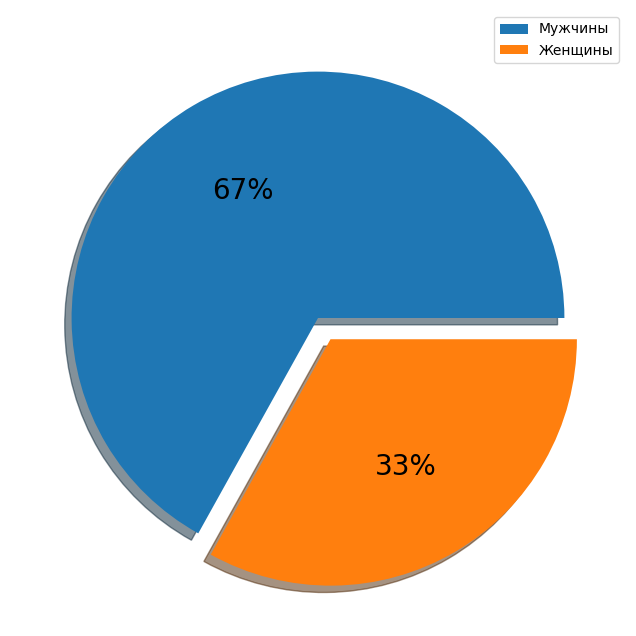

In [38]:
plt.figure(figsize=(8,8))
plt.pie(df['Пол'].value_counts(), explode=[0, 0.1], shadow=True, autopct='%1.0f%%', textprops={'fontsize': 20})
plt.legend(['Мужчины', 'Женщины'])
plt.show()

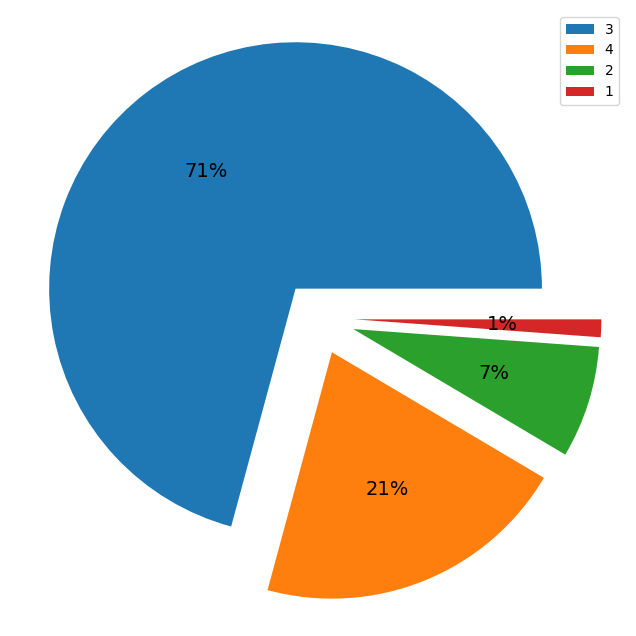

In [39]:
plt.figure(figsize=(8,8))
plt.pie(df['Образование'].value_counts(), explode=[0.15, 0.15, 0.15, 0.15], autopct='%1.0f%%', textprops={'fontsize': 14})
plt.legend(df['Образование'].value_counts().index)
plt.show()

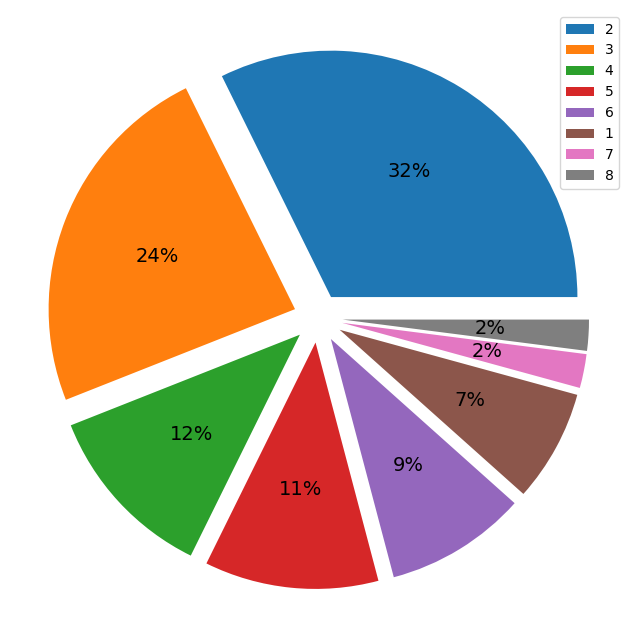

In [40]:
plt.figure(figsize=(8,8))
plt.pie(df['Уровень должности'].value_counts(), explode=[0.1]*8, autopct='%1.0f%%', textprops={'fontsize': 14})
plt.legend(df['Уровень должности'].value_counts().index)
plt.show()

Вывод на основе полученных диаграмм:
- доля мужчин в 2 раза больше, чем доля женщин
- количество людей с образованием 3 в 2 раза больше, чем остальных 
- уровни должности 2 и 3 составляют половину от всей выборки  

Рассмотрим распределение по половому признаку для уровня образования и уровня должности

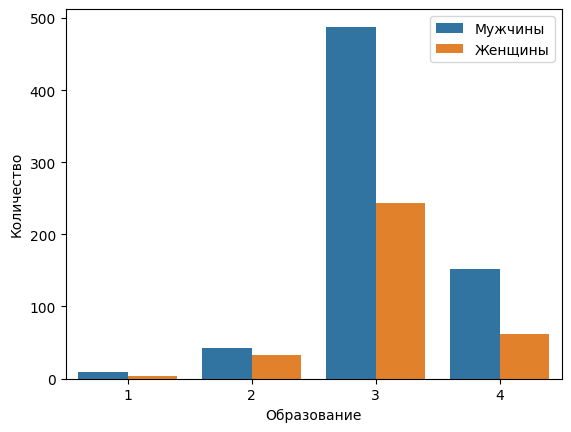

In [41]:
sns.countplot(data=df, x='Образование', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

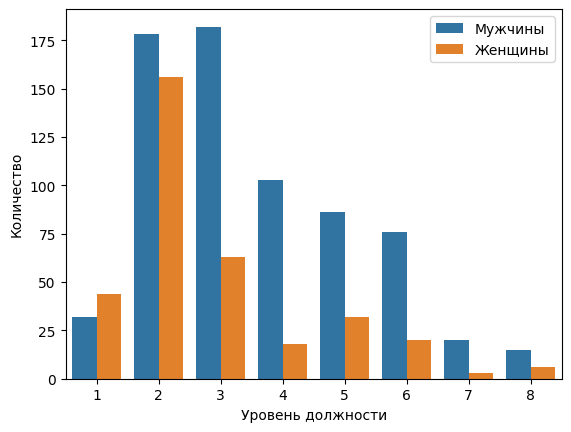

In [42]:
sns.countplot(data=df, x='Уровень должности', hue='Пол')
plt.ylabel('Количество')
plt.legend(['Mужчины', 'Женщины'])
plt.show()

Вывод на основе столбчатых диаграмм:
- сохраняется отношение между количеством мужчин и женщин вне зависимости от уровня образования
- с увелечинием уровня должности количество мужчин более сильно преобладает над количеством женщин  

## Рассмотрение корреляции признаков

interval columns not set, guessing: ['Пол', 'Образование', 'Уровень должности', 'Настороженность', 'Расчётливость', 'Жёсткость', 'Независимость', 'Авантюризм', 'Непрактичность', 'Осторожность', 'Нормативность', 'Жертвенность', 'Эмоциональность', 'Расслабленность', 'Безынициативность']


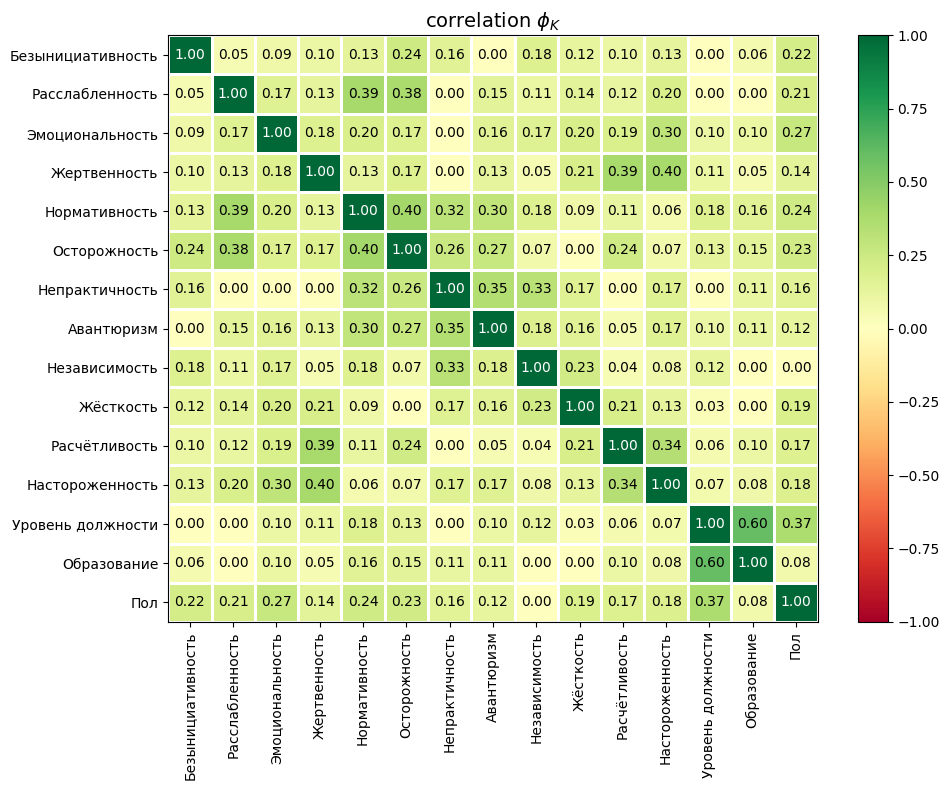

In [43]:
phik_corr = df.phik_matrix()
phik.report.plot_correlation_matrix(phik_corr.values, x_labels=phik_corr.columns,
                                    y_labels=phik_corr.index, title=r'correlation $\phi_K$',  fontsize_factor=1, figsize=(10, 8))

Образование и Уровень должности коррелириют между собой

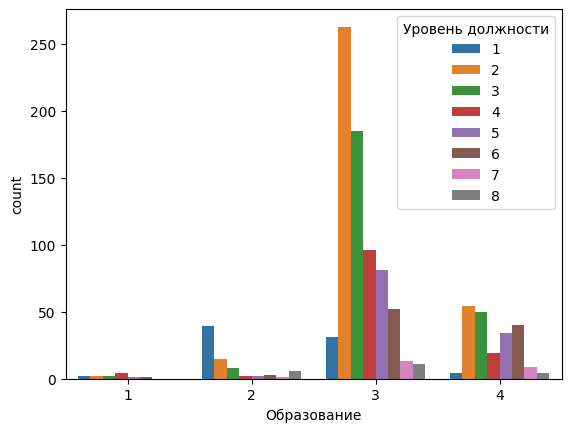

In [44]:
sns.countplot(data=df,  hue='Уровень должности', x='Образование')
plt.show()

## Кластеризация и ее последующий анализ

In [45]:
columns = df.columns[3:]

def find_variance(data):
    for column in columns:
        print(f'{column}: {round(np.var(data[column]), 2)}')


In [46]:
def create_clusters(predicted_labels):
    clusterd_df = []
    clusters = np.unique(predicted_labels)
    for cluster in clusters:
        row_ix = np.where(predicted_labels == cluster)
        clusterd_df.append(df.iloc[list(*row_ix)])
    return clusterd_df

In [47]:
def cluster_info(cluster):
    for i in range(2):        
        print(f'Значения дисперсий {i+1} кластера:')
        find_variance(cluster[i])
        print('-'*100)
        

In [48]:
scaler = MinMaxScaler()
X = df.iloc[:, 3:]
X = scaler.fit_transform(X)

Берем 4 кластера, так у нас 4 уровня образования и должность коррелирует с образовыанием

In [49]:
model = KMeans(n_clusters=4, n_init='auto', max_iter=1000)
model = model.fit(X)
predict = model.predict(X)
clusterd_df = create_clusters(predict)
cluster_info(clusterd_df)

Значения дисперсий 1 кластера:
Настороженность: 825.77
Расчётливость: 605.08
Жёсткость: 887.04
Независимость: 783.84
Авантюризм: 601.06
Непрактичность: 598.41
Осторожность: 332.53
Нормативность: 289.22
Жертвенность: 571.3
Эмоциональность: 531.34
Расслабленность: 413.77
Безынициативность: 715.09
----------------------------------------------------------------------------------------------------
Значения дисперсий 2 кластера:
Настороженность: 728.54
Расчётливость: 789.03
Жёсткость: 777.19
Независимость: 888.0
Авантюризм: 724.57
Непрактичность: 699.88
Осторожность: 530.89
Нормативность: 744.69
Жертвенность: 658.29
Эмоциональность: 817.92
Расслабленность: 744.19
Безынициативность: 816.31
----------------------------------------------------------------------------------------------------


In [50]:
print(f'Значения дисперсии всей выборки:')
find_variance(df)

Значения дисперсии всей выборки:
Настороженность: 760.62
Расчётливость: 883.15
Жёсткость: 1017.86
Независимость: 917.76
Авантюризм: 907.77
Непрактичность: 818.87
Осторожность: 595.88
Нормативность: 804.22
Жертвенность: 1095.01
Эмоциональность: 758.89
Расслабленность: 737.57
Безынициативность: 841.14


Заметим, что значения дисперсии очень похожи, из чего можно предположить, что признаки каждого кластера распределены таким же образом, как и в исходной выборке

In [51]:
datasets = [df, clusterd_df[0], clusterd_df[1]]
from_0_to_3_columns = columns[0:4]
from_4_to_7_columns = columns[4:8]
from_8_to_12_columns = columns[8:12]

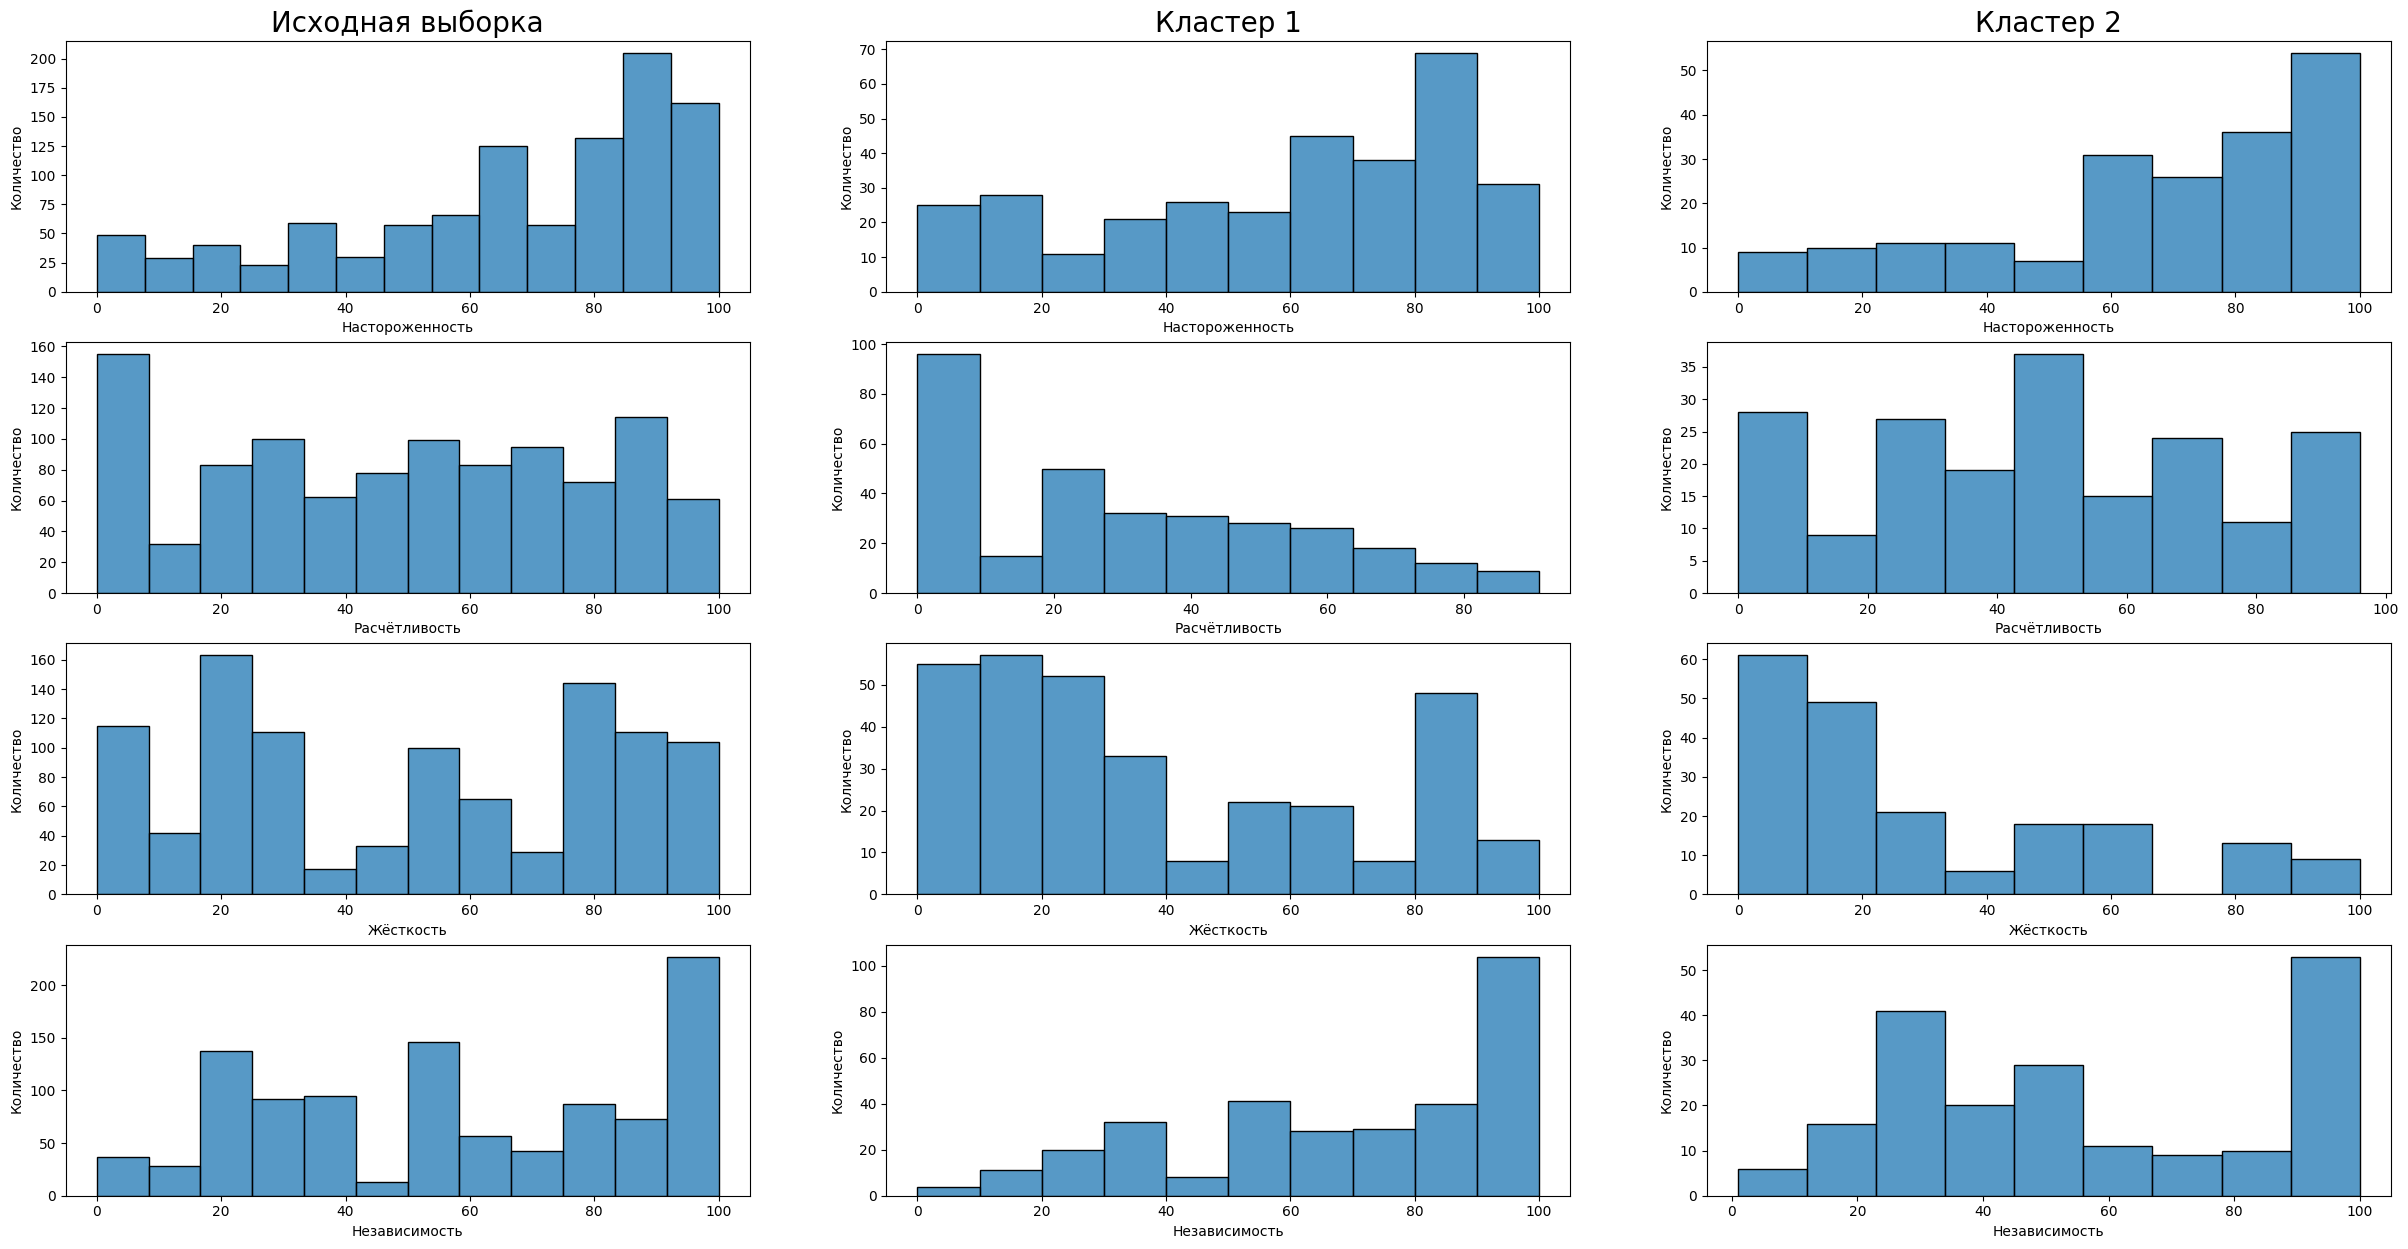

In [52]:
fig, ax = plt.subplots(4, 3, figsize=(30, 15))
ax[0][0].set_title('Исходная выборка',fontdict = {'fontsize': 20})
ax[0][1].set_title('Кластер 1', fontdict = {'fontsize': 20})
ax[0][2].set_title('Кластер 2', fontdict = {'fontsize': 20})
h = 0
for i in range(4):
    for j in range(3):
        dataset = datasets[h%3]
        sns.histplot(ax=ax[i][j], data=dataset, x=from_0_to_3_columns[i])
        ax[i][j].set_ylabel('Количество')
        h += 1

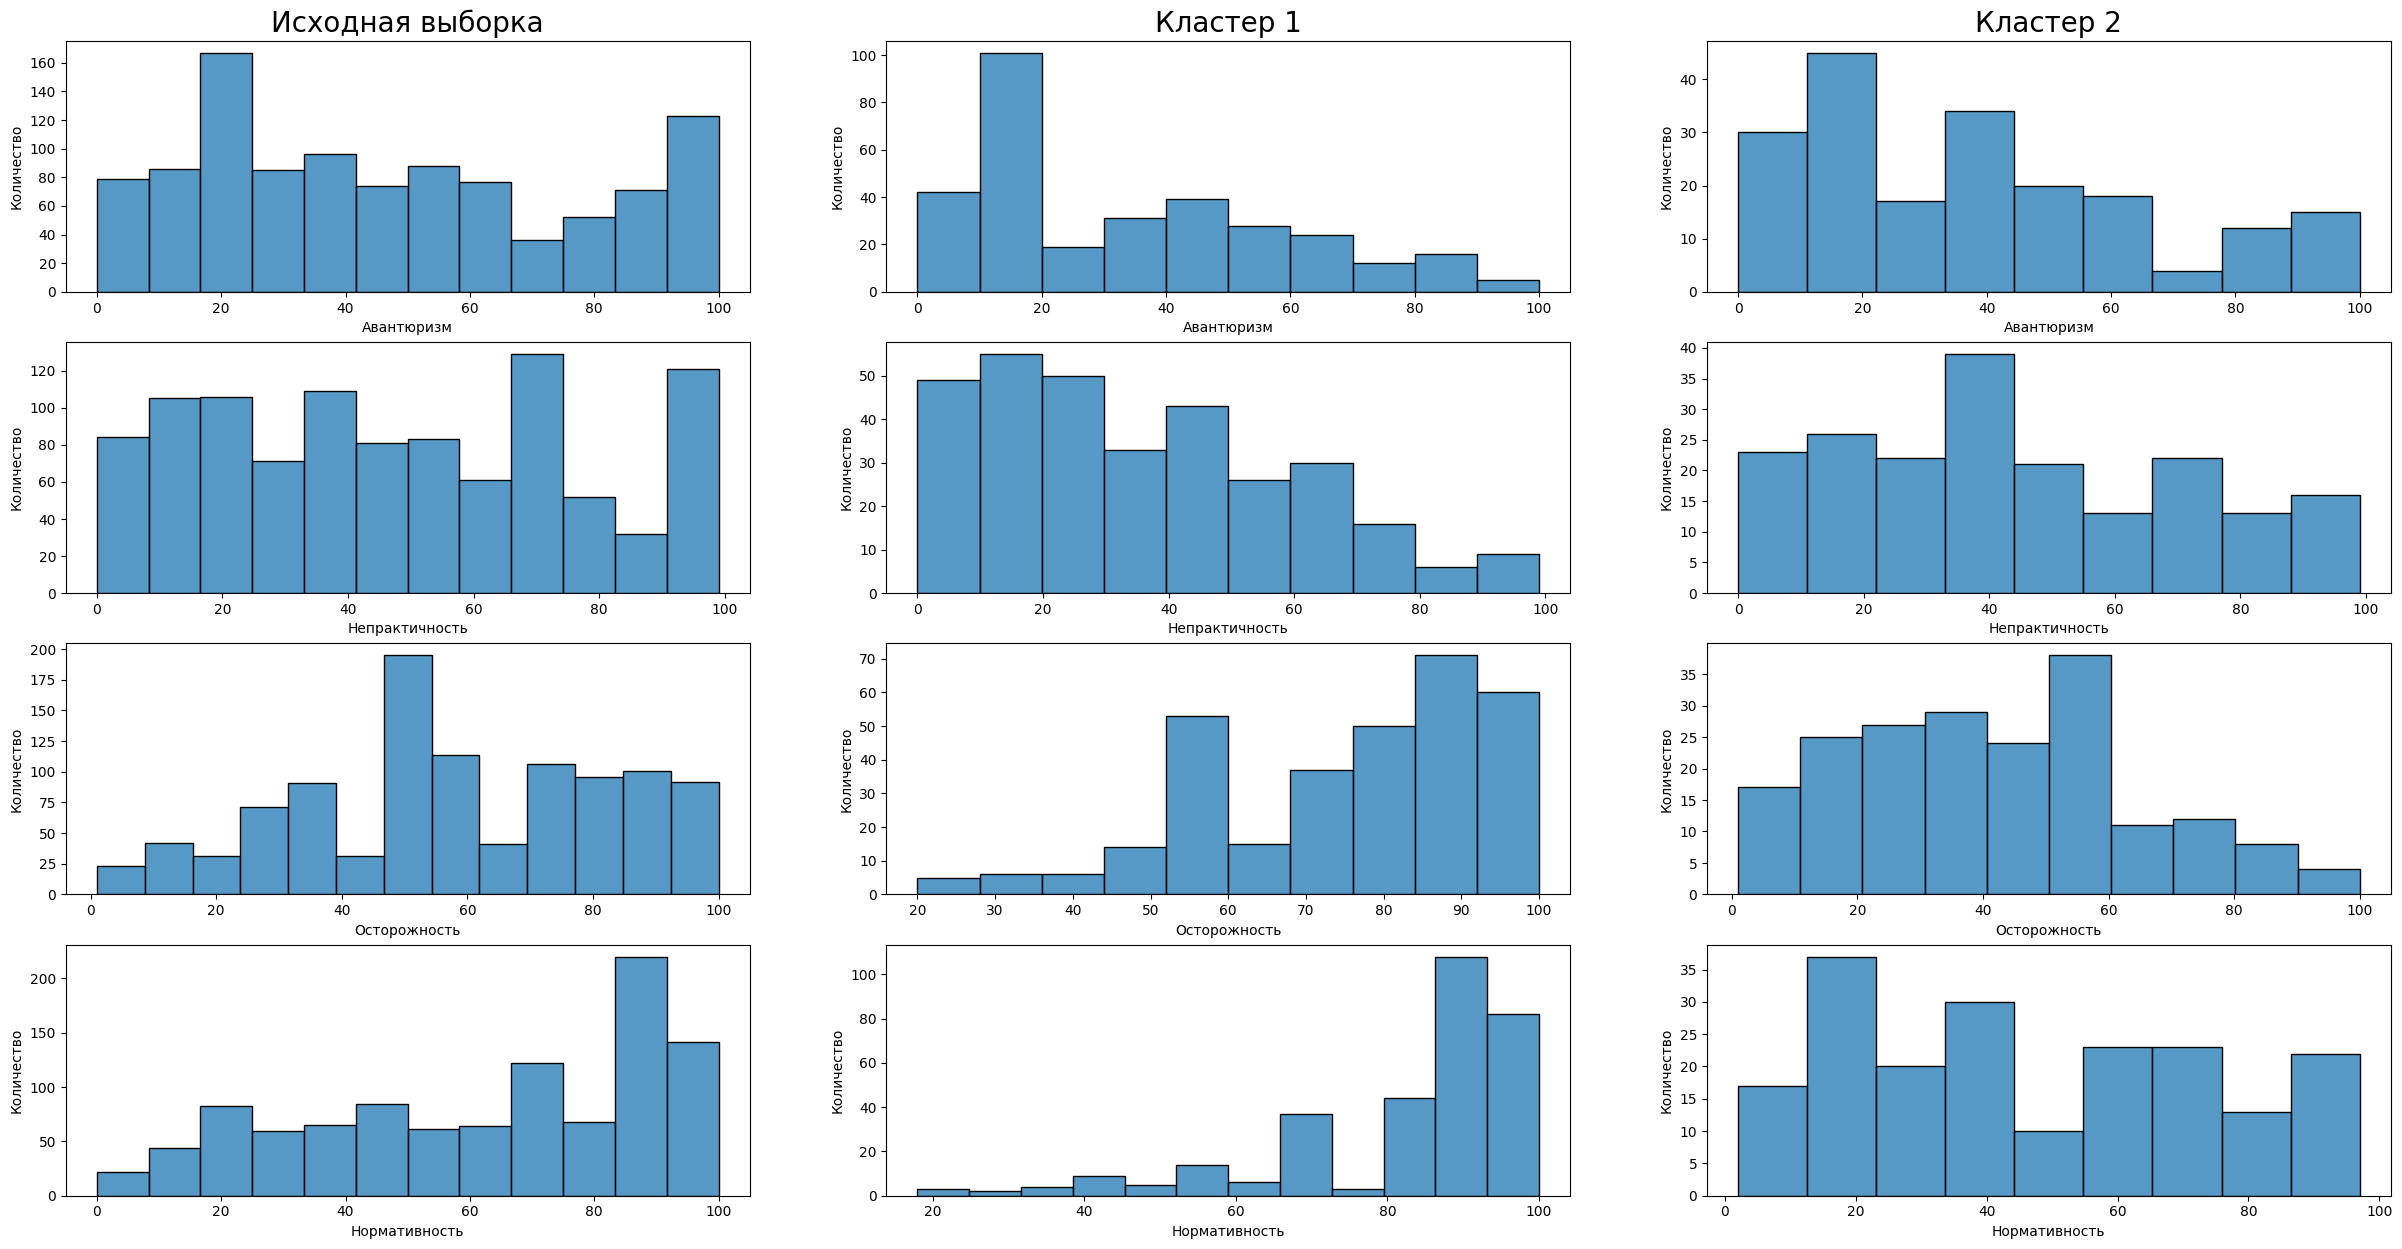

In [53]:
fig, ax = plt.subplots(4, 3, figsize=(30, 15))
ax[0][0].set_title('Исходная выборка',fontdict = {'fontsize': 20})
ax[0][1].set_title('Кластер 1', fontdict = {'fontsize': 20})
ax[0][2].set_title('Кластер 2', fontdict = {'fontsize': 20})
h = 0
for i in range(4):
    for j in range(3):
        dataset = datasets[h%3]
        sns.histplot(ax=ax[i][j], data=dataset, x=from_4_to_7_columns[i])
        ax[i][j].set_ylabel('Количество')
        h += 1

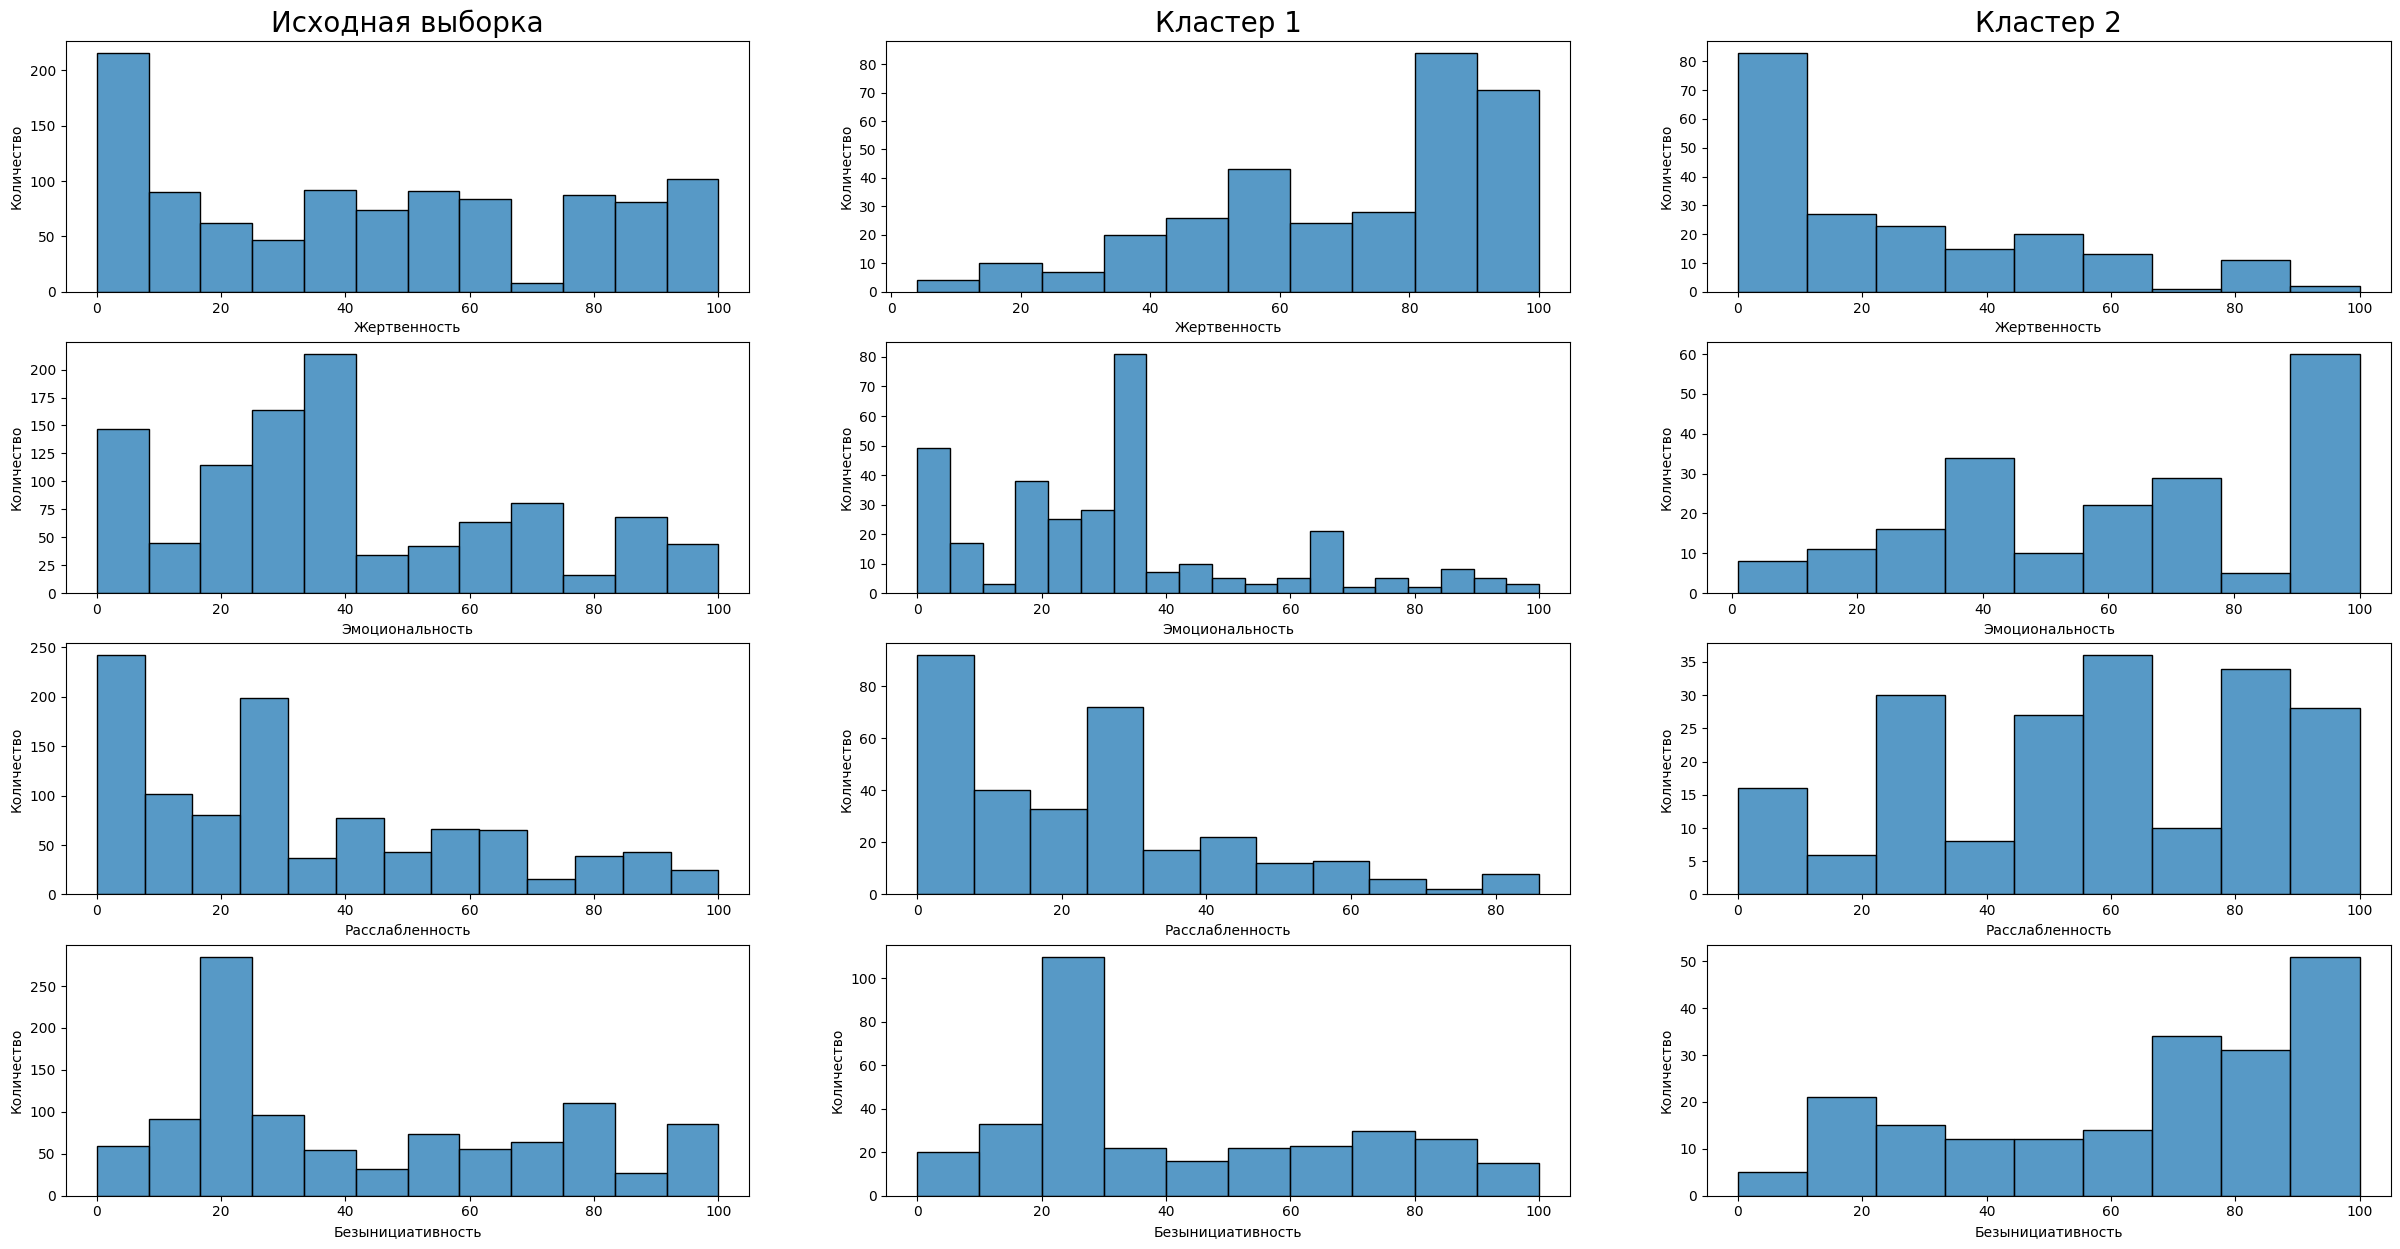

In [54]:
fig, ax = plt.subplots(4, 3, figsize=(30, 15))
ax[0][0].set_title('Исходная выборка',fontdict = {'fontsize': 20})
ax[0][1].set_title('Кластер 1', fontdict = {'fontsize': 20})
ax[0][2].set_title('Кластер 2', fontdict = {'fontsize': 20})
h = 0
for i in range(4):
    for j in range(3):
        dataset = datasets[h%3]
        sns.histplot(ax=ax[i][j], data=dataset, x=from_8_to_12_columns[i])
        ax[i][j].set_ylabel('Количество')
        h += 1

Наше предположение относительно схожести распределений оказалось верным 

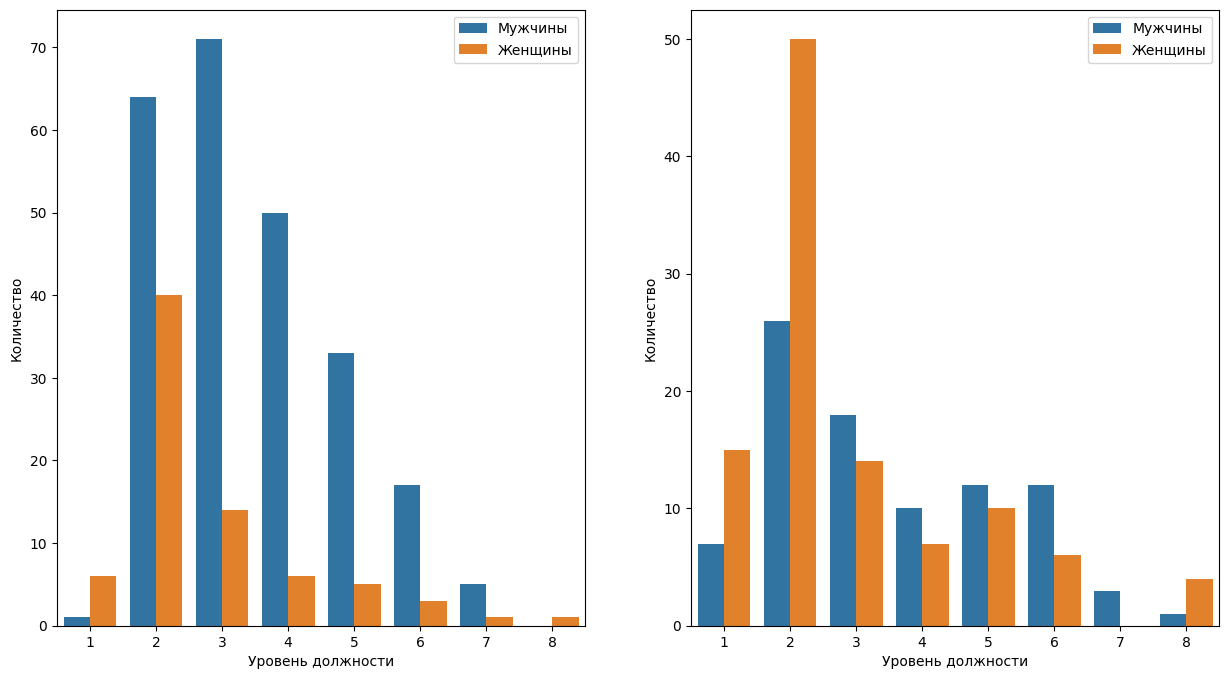

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
sns.countplot(data=clusterd_df[0], x='Уровень должности', hue='Пол', ax=axs[0])
sns.countplot(data=clusterd_df[1], x='Уровень должности', hue='Пол', ax=axs[1])
axs[0].set_ylabel('Количество')
axs[0].legend(['Mужчины', 'Женщины'])
axs[1].set_ylabel('Количество')
axs[1].legend(['Mужчины', 'Женщины'])
plt.show()

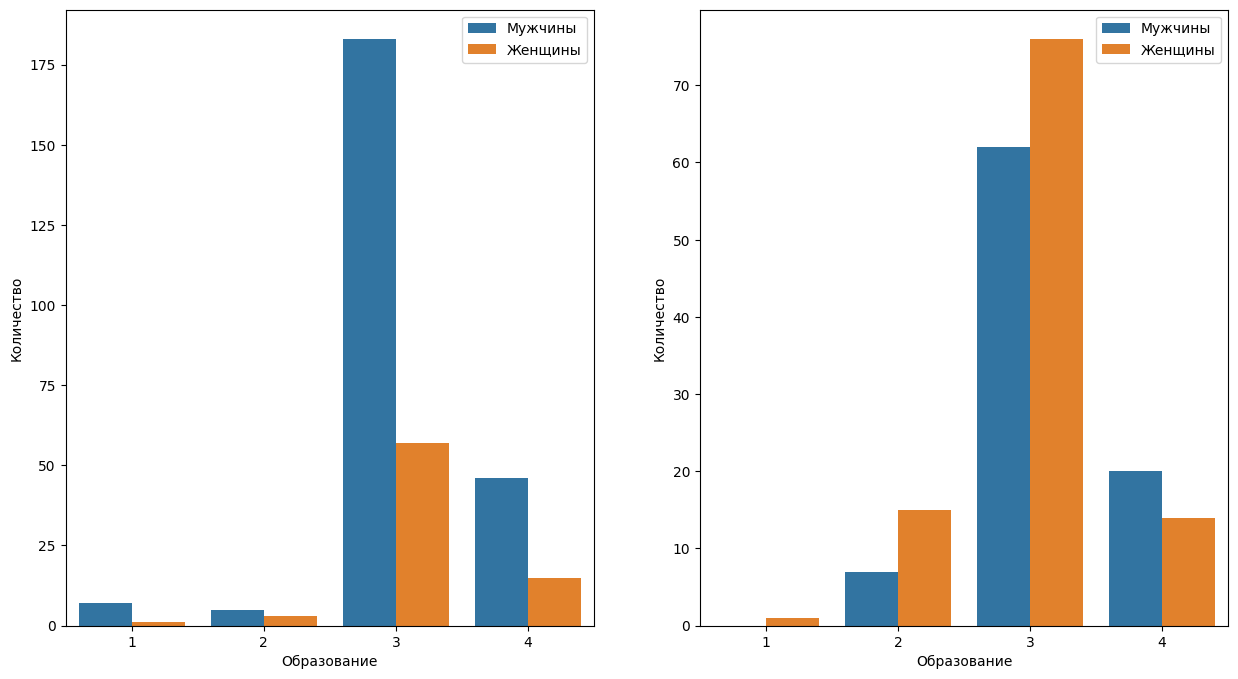

In [56]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 8))
sns.countplot(data=clusterd_df[0], x='Образование', hue='Пол', ax=axs[0])
sns.countplot(data=clusterd_df[1], x='Образование', hue='Пол', ax=axs[1])
axs[0].set_ylabel('Количество')
axs[0].legend(['Mужчины', 'Женщины'])
axs[1].set_ylabel('Количество')
axs[1].legend(['Mужчины', 'Женщины'])
plt.show()

Полученные графики отражают действительность, так как у определенной группы людей (кластеров) будет преобладать определенные человеческие качества.


# Вывод 

- В данной работе была проверена валидация группы людей для последующего принятия решений
- Были прочитаны данные с предварительными выводами, выдвинуты гипотезы 
- После этого была произведена обработка данных
- Затем был проведен исслдеовательский анализ данных
- На основе полученных данных были сделаны выводы: кол-во мужчин в 2 раза превышает кол-во женщин вне зависимости от уровня образования, большая часть людей имеет образование 3 и должность (2, 3)
- После этого была провведена кластеризация с дальнейшим анализом кластеров
- На основе результатов кластерного анализа было выяснено, что выборка является валидной